# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to cluster Toronto neighborhood in Canada based on different restaurant available near to the location.

Since there are lots of restaurants in Toronto it is hard to find group neighborhoods based on restaurant type. Here we will use infomation about the restaurants available in each neighborhood in Toronto, Canada and create a model which can tell the most and least avaiable restaurant types in a particular neighborhood.

It can help both who is looking for places where a particular type of restaurant is available and also some one who is looking for places where a particular type of restaurant is not available thus that type of restaurant can be opened in that area to run a business.

**Import all required libraries for this project**

In [162]:
from bs4 import BeautifulSoup as bs

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#!pip install folium
import folium # map rendering library

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* total number of neighborhoods in Toronto, Canada
* number of different types of restaurant in each neighborhood

Following data sources will be needed to extract/generate the required information:
* location of every neighborhoods in Canada using wiki informationa and a given csv file.
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Toronto will be obtained using **Google Maps API geocoding**.

**First we will fetch the postal code list of Canada from the below wiki link using web scraping and store it to a pandas dataframe**

In [163]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
soup = bs(response.text, 'html.parser')

In [164]:
neighborhoods = pd.DataFrame(columns = ['PostalCode','Borough','Neighborhood'])
listcode=[]
for row in soup.find('table',{'class': 'wikitable sortable'}).find_all('tr'):
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    
    if len(cols)>0:
        #print (cols)
        listcode.append([ele for ele in cols if ele])

neighborhoods[['PostalCode','Borough','Neighborhood']] = pd.DataFrame(listcode)
neighborhoods.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Data cleaning

1. Borough having **Not assigned** will be droped from dataframe. 
2. Concat neighborhoods having same borough.
3. Neighborhood having **Not assigned** will be same as borough

In [165]:
neighborhoods = neighborhoods[neighborhoods['Borough'] != 'Not assigned']

neighborhoods['Neighborhood']=neighborhoods.groupby('PostalCode')['Neighborhood'].transform(lambda x: ','.join(x))
neighborhoods= neighborhoods[['PostalCode','Borough','Neighborhood']].drop_duplicates()
neighborhoods.reset_index(inplace =True, drop=True)

for i, rw in neighborhoods.iterrows():
    #print (rw)
    if rw['Neighborhood'] == 'Not assigned':
        rw['Neighborhood']=rw['Borough']

neighborhoods.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront,Regent Park"
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


Import the below csv file to get the location details for the neighborhoods in above dataframe

In [166]:
Geospatial_data = pd.read_csv("Geospatial_Coordinates.csv")

input_data= Geospatial_data[Geospatial_data['Postal Code'].isin(neighborhoods['PostalCode'].tolist())]

neighborhoods_data= neighborhoods.merge(input_data, left_on = 'PostalCode', right_on ='Postal Code')

neighborhoods_data.drop(columns='Postal Code',inplace = True)

neighborhoods_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


### Foursquare

Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood.

We're interested in venues in 'food' category so we will use **4d4b7105d754a06374d81259** category Id to fetch the food related venues  at the neighborhood.

In [167]:
CLIENT_ID = 'NOWVY3EIW3AN4G2JOX21OYJTZPEA23IGUMLA2MGOU1U142TA' # your Foursquare ID
CLIENT_SECRET = 'BNH3FQPLTTTRKKUZDCRWZ1RATKNFYYHZHYKM0PVBIYQS55KK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [168]:
def getNearByVenue(borough, neighborhood, latitude, longitude):
    venue_list = []
    for borough, name, lat, lng in zip(borough, neighborhood, latitude, longitude):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat, 
        lng,
        radius,
        categoryId,
        limit)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for v in results:
            v_name = v['venue']['name']
            v_lat = v['venue']['location']['lat'] 
            v_lng = v['venue']['location']['lng']
            if len(v['venue']['categories']) == 0:
                v_cat = 'N/A'
            else:
                v_cat = v['venue']['categories'][0]['name']
            
            venue_list.append([(
                borough,
                name, 
                lat, 
                lng, 
                v_name,
                v_lat, 
                v_lng,  
                v_cat)])
        
    nearby_venues = pd.DataFrame([item for venue_list in venue_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',           
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [129]:
categoryId = '4d4b7105d754a06374d81259'  # food
radius= 500
limit = 100

venue_data = getNearByVenue(neighborhoods_data['Borough'],
                               neighborhoods_data['Neighborhood'], 
                               neighborhoods_data['Latitude'], 
                               neighborhoods_data['Longitude'])

venue_data.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,North York,Parkwoods,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
2,North York,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
3,North York,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
4,North York,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place


In [169]:
venue_data.shape

(1685, 8)

Now based on our analysis there are total 1685 food vanues found in Canada from our dataframe. Amoung all the venues filter the dataframe which are at Toronto borough.

In [170]:
venue_Toronto = venue_data[venue_data['Borough'].str.contains("Toronto")]
venue_Toronto.reset_index(inplace =True, drop=True)
venue_Toronto.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"Harbourfront,Regent Park",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
1,Downtown Toronto,"Harbourfront,Regent Park",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
2,Downtown Toronto,"Harbourfront,Regent Park",43.65426,-79.360636,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
3,Downtown Toronto,"Harbourfront,Regent Park",43.65426,-79.360636,Brick Street Bakery,43.650574,-79.359539,Bakery
4,Downtown Toronto,"Harbourfront,Regent Park",43.65426,-79.360636,El Catrin,43.650601,-79.358920,Mexican Restaurant


In [171]:
venue_Toronto.shape

(1358, 8)

The primary dataframe has **1358** restaurant details.

## Methodology <a name="methodology"></a>


In this project we are going to find available restaurants around each neighborhood and based on their category we are going to cluster the neighborhoods.

We have already collected data of the food places around each neighborhood at Toronto.

Next we are going to analyze this data to find top five types of restaurants based on their count in each neighborhood.

Later from the cluster analysis we will get an idea about different places and with a particular type of restaurant which is msost available and also least available.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the different types of **restaurants in every area candidate**:

In [172]:
pd.set_option('display.max_rows', 500)
venue_Toronto['Venue Category'].value_counts().sort_values(ascending=False)

Café                               127
Restaurant                          96
Italian Restaurant                  80
Pizza Place                         66
Sandwich Place                      61
Bakery                              53
Sushi Restaurant                    46
American Restaurant                 44
Japanese Restaurant                 39
Fast Food Restaurant                38
Breakfast Spot                      33
Steakhouse                          31
Seafood Restaurant                  31
Burger Joint                        31
Deli / Bodega                       30
Chinese Restaurant                  29
Greek Restaurant                    28
Thai Restaurant                     28
Salad Place                         28
Vegetarian / Vegan Restaurant       27
Asian Restaurant                    25
Gastropub                           24
Diner                               22
Mexican Restaurant                  21
Burrito Place                       17
Middle Eastern Restaurant

Now define a list of restaurant categories we will focus on for this project.

In [173]:
restaurant_categories = ['Chinese Restaurant', 'Italian Restaurant', 'Mexican Restaurant', 'New American Restaurant', 
                         'Fast Food Restaurant', 'Sushi Restaurant', 'Japanese Restaurant', 'Thai Restaurant', 
                         'Seafood Restaurant', 'Indian Restaurant', 'French Restaurant', 'Asian Restaurant', 
                         'Greek Restaurant']

Lets filter the data based on the defined restaurant categories.

In [174]:
rest_Toronto = venue_Toronto[venue_Toronto['Venue Category'].isin(restaurant_categories)]
delta = venue_Toronto.shape[0] - rest_Toronto.shape[0]
print("{} Entries were removed".format(delta))
rest_Toronto.head()

953 Entries were removed


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4,Downtown Toronto,"Harbourfront,Regent Park",43.65426,-79.360636,El Catrin,43.650601,-79.358920,Mexican Restaurant
5,Downtown Toronto,"Harbourfront,Regent Park",43.65426,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
8,Downtown Toronto,"Harbourfront,Regent Park",43.65426,-79.360636,Cocina Economica,43.654959,-79.365657,Mexican Restaurant
10,Downtown Toronto,"Harbourfront,Regent Park",43.65426,-79.360636,Souvlaki Express,43.655584,-79.364438,Greek Restaurant
13,Downtown Toronto,"Harbourfront,Regent Park",43.65426,-79.360636,Archeo,43.650667,-79.359431,Italian Restaurant


### One-Hot-Encoding venue categories

To use Foursquare’s category values to find similar neighborhoods based on restaurant types, a one-hot-encoding representation of each entry will be created using Pandas’ ‘get_dummies’ function. The result was a dataframe restaurant related venues of Toronto where entry venue category is represented by a value of 1 in the column of matching venue category.

In [175]:
rest_Toronto_cat = pd.get_dummies(rest_Toronto[['Venue Category']], prefix='', prefix_sep='')
rest_Toronto_cat['Neighborhood'] = rest_Toronto['Neighborhood']
fixed_col = [rest_Toronto_cat.columns[-1]] + list (rest_Toronto_cat.columns[:-1])
rest_Toronto_cat = rest_Toronto_cat[fixed_col]
rest_Toronto_cat.head(10)

,Neighborhood,Asian Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,New American Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant
4,"Harbourfront,Regent Park",0,0,0,0,0,0,0,0,1,0,0,0,0
5,"Harbourfront,Regent Park",0,0,0,1,0,0,0,0,0,0,0,0,0
8,"Harbourfront,Regent Park",0,0,0,0,0,0,0,0,1,0,0,0,0
10,"Harbourfront,Regent Park",0,0,0,0,1,0,0,0,0,0,0,0,0
13,"Harbourfront,Regent Park",0,0,0,0,0,0,1,0,0,0,0,0,0
14,"Harbourfront,Regent Park",1,0,0,0,0,0,0,0,0,0,0,0,0
15,"Harbourfront,Regent Park",0,0,0,0,0,0,0,0,0,0,1,0,0
17,"Harbourfront,Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,1
18,"Harbourfront,Regent Park",0,1,0,0,0,0,0,0,0,0,0,0,0
20,"Harbourfront,Regent Park",0,0,0,0,0,0,0,1,0,0,0,0,0


### Data Visualization

Number of different restaurant category for each neighborhood will be calculated using the onehotencoding dataframe.

Calculate total number of each restaurant category in each neighborhood.

In [176]:
toronto_rest_sum = rest_Toronto_cat.groupby('Neighborhood').sum()
toronto_rest_sum.head()

,Asian Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,New American Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant
Neighborhood,,,,,,,,,,,,,
"Adelaide,King,Richmond",6,1,1,0,1,1,2,1,2,1,2,3,4
Berczy Park,0,0,0,2,2,1,4,0,1,0,2,2,1
"Brockton,Exhibition Place,Parkdale Village",0,0,0,0,0,0,1,1,0,0,0,0,0
Business Reply Mail Processing Centre 969 Eastern,0,0,2,0,0,0,0,0,0,0,0,0,0
"Cabbagetown,St. James Town",0,2,0,0,0,1,2,1,0,0,0,1,1


Lets plot a histogram to visualize the relation between neighborhoods with categories.

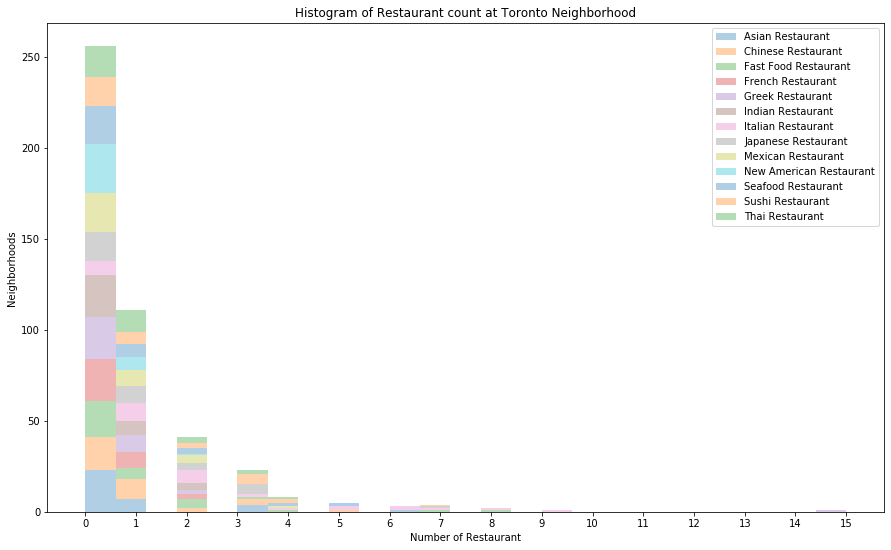

In [177]:
count1, bin_edg = np.histogram(toronto_rest_sum,15)
toronto_rest_sum.plot(kind ='hist', xticks =bin_edg, bins=25, alpha =0.35,figsize=(15,9),stacked = True)

#toronto_rest_sum.plot(kind='hist', figsize=(10, 6))

plt.title('Histogram of Restaurant count at Toronto Neighborhood')
plt.ylabel('Neighborhoods')
plt.xlabel('Number of Restaurant')

plt.show()

Lets find out the top five restaurant present in out dataframe.

In [178]:
top_rest = toronto_rest_sum.sum().sort_values(ascending=False)
top_rest_toronto = top_rest.head(5).index.tolist()
top_rest_toronto

['Italian Restaurant',
 'Sushi Restaurant',
 'Japanese Restaurant',
 'Fast Food Restaurant',
 'Seafood Restaurant']

Now lets plot bar plots to visualize top 20 neighborhoods with most five popular restaurant categories.

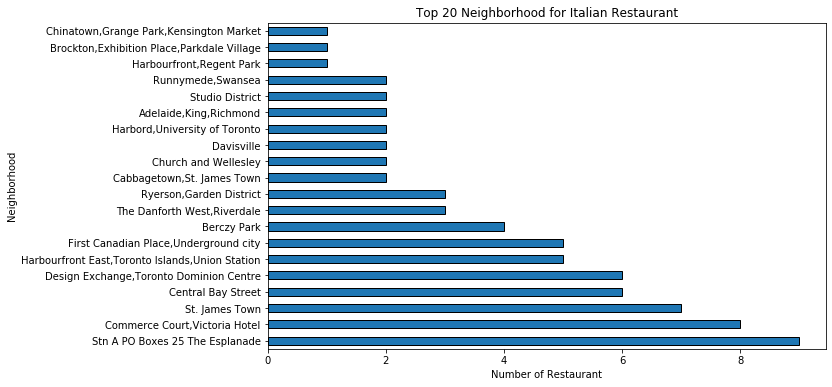

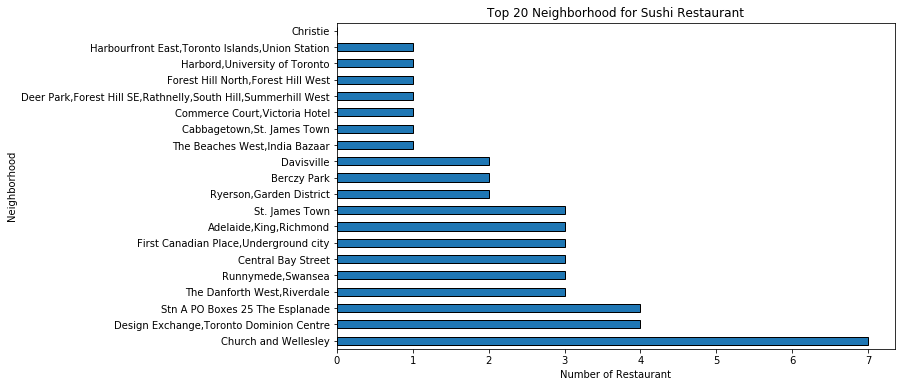

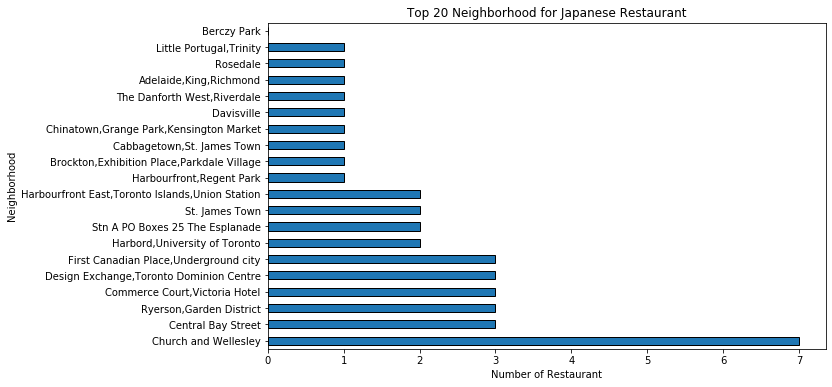

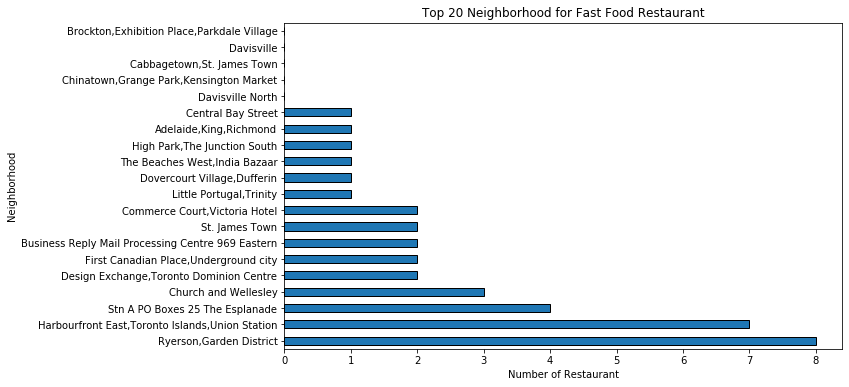

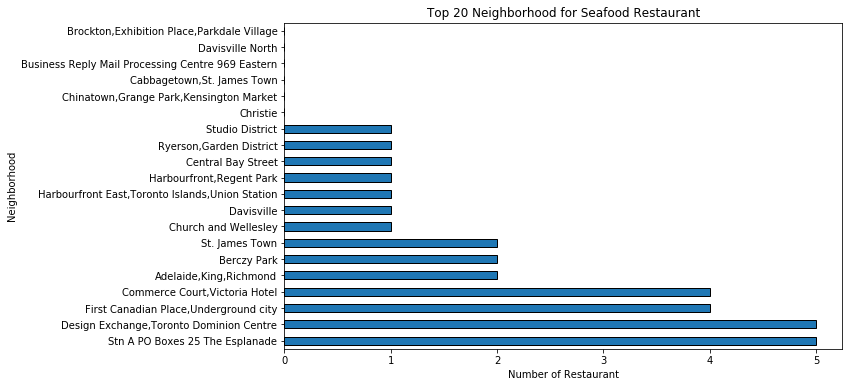

In [179]:
count = 20

for rest in top_rest_toronto:
    top_cust_toronto = toronto_rest_sum.transpose().loc[rest].sort_values(ascending= False).head(count)
    plt.figure(num=None)
    
    plt.xlabel('Number of Restaurant') # add to x-label to the plot
    plt.ylabel('Neighborhood names') # add y-label to the plot
    plt.title(f'Top {count} Neighborhood for {rest}') # add title to the plot
    top_cust_toronto.plot(kind='barh', figsize=(10, 6), edgecolor = 'k')

### Feature creation

Using the one-hot encoded dataframe we will calculate the percentage distribution for each categoty

In [180]:
toronto_grouped = rest_Toronto_cat.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Asian Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,New American Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant
0,"Adelaide,King,Richmond",0.24,0.04,0.04,0.000000,0.040000,0.040000,0.080000,0.040,0.080000,0.04,0.080000,0.120000,0.160000
1,Berczy Park,0.00,0.00,0.00,0.133333,0.133333,0.066667,0.266667,0.000,0.066667,0.00,0.133333,0.133333,0.066667
2,"Brockton,Exhibition Place,Parkdale Village",0.00,0.00,0.00,0.000000,0.000000,0.000000,0.500000,0.500,0.000000,0.00,0.000000,0.000000,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.00,0.00,1.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00,0.000000,0.000000,0.000000
4,"Cabbagetown,St. James Town",0.00,0.25,0.00,0.000000,0.000000,0.125000,0.250000,0.125,0.000000,0.00,0.000000,0.125000,0.125000


Lets find out the **top five** restaurant categories for each neighborhood.

In [181]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [182]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide,King,Richmond",Asian Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Mexican Restaurant
1,Berczy Park,Italian Restaurant,Sushi Restaurant,Seafood Restaurant,Greek Restaurant,French Restaurant
2,"Brockton,Exhibition Place,Parkdale Village",Japanese Restaurant,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,New American Restaurant
4,"Cabbagetown,St. James Town",Italian Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Japanese Restaurant


Using the above data a DataFrame with Bottom **five categories** for each neiborhoods is created

In [183]:
def return_least_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [194]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of least venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_bt = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_bt['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted_bt.iloc[ind, 1:] = return_least_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_bt.head()

,Neighborhood,1st least Common Venue,2nd least Common Venue,3rd least Common Venue,4th Least Common Venue,5th Least Common Venue
0,"Adelaide,King,Richmond",French Restaurant,Chinese Restaurant,Fast Food Restaurant,Greek Restaurant,Indian Restaurant
1,Berczy Park,Asian Restaurant,Chinese Restaurant,Fast Food Restaurant,Japanese Restaurant,New American Restaurant
2,"Brockton,Exhibition Place,Parkdale Village",Asian Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Asian Restaurant,Chinese Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant
4,"Cabbagetown,St. James Town",Asian Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Mexican Restaurant


## Results and Discussion <a name="results"></a>

### Clustering

Using Scikit learn's K means clustering algorithm we are going to cluster the neighborhoods based on the available retaurant types. Before feeding the data to fit the model we are going to mormalize the data set using Standard scaler method

In [185]:
from sklearn.preprocessing import StandardScaler

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# transform the data
scaler = StandardScaler(with_std= True)
print(scaler.fit(toronto_grouped_clustering))
print(scaler.transform(toronto_grouped_clustering).shape)

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scaler.transform(toronto_grouped_clustering))

# check cluster labels generated for each row in the dataframe
kmeans.labels_

StandardScaler(copy=True, with_mean=True, with_std=True)
(35, 13)


array([1, 1, 2, 1, 2, 2, 3, 4, 2, 1, 1, 0, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       4, 3, 4, 2, 2, 1, 1, 1, 1, 0, 0, 2, 1])

Now insert the labels in our top venue categories dataframe.

In [186]:
neighborhoods_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide,King,Richmond",1,Asian Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Mexican Restaurant
1,Berczy Park,1,Italian Restaurant,Sushi Restaurant,Seafood Restaurant,Greek Restaurant,French Restaurant
2,"Brockton,Exhibition Place,Parkdale Village",2,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,1,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,New American Restaurant
4,"Cabbagetown,St. James Town",2,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Japanese Restaurant


Now join this above dataframe with our main NYC neighborhood data frame with location data.

In [187]:
toronto_merged = neighborhoods_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how ='right')

toronto_merged.reset_index(inplace =True, drop=True)

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636,1,Mexican Restaurant,Thai Restaurant,Seafood Restaurant,Japanese Restaurant,Italian Restaurant
1,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937,1,Fast Food Restaurant,Thai Restaurant,Japanese Restaurant,Italian Restaurant,Chinese Restaurant
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Italian Restaurant,Sushi Restaurant,Seafood Restaurant,Japanese Restaurant,Indian Restaurant
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Asian Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,New American Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Italian Restaurant,Sushi Restaurant,Seafood Restaurant,Greek Restaurant,French Restaurant


In [188]:
toronto_merged.shape

(35, 11)

In [197]:
df_cluster = toronto_merged.sort_values('Cluster Labels', ascending = False)
df_cluster.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
22,M6R,West Toronto,"Parkdale,Roncesvalles",43.648960,-79.456325,4,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,New American Restaurant
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,4,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,New American Restaurant
26,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160,4,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,New American Restaurant
27,M5T,Downtown Toronto,"Chinatown,Grange Park,Kensington Market",43.653206,-79.400049,3,Chinese Restaurant,Mexican Restaurant,Thai Restaurant,Japanese Restaurant,Italian Restaurant
20,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,3,Mexican Restaurant,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant
28,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049,2,Sushi Restaurant,Thai Restaurant,Seafood Restaurant,New American Restaurant,Mexican Restaurant
24,M5S,Downtown Toronto,"Harbord,University of Toronto",43.662696,-79.400049,2,Japanese Restaurant,Italian Restaurant,Sushi Restaurant,French Restaurant,Chinese Restaurant
14,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,2,Sushi Restaurant,Italian Restaurant,Fast Food Restaurant,Thai Restaurant,Seafood Restaurant
13,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191,2,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant
25,M6S,West Toronto,"Runnymede,Swansea",43.651571,-79.484450,2,Sushi Restaurant,Italian Restaurant,French Restaurant,Thai Restaurant,Seafood Restaurant


Lets get the location details of Toranto, Canada using **Google Maps API geocoding**.

In [189]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of toronto are 43.653963, -79.387207.


### Cluster Vizualization

Let's vizualize the clusters on Toronto map using folium.

In [190]:
# create map of toronto
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Evaluation

From the above visualization we can see the similar neighborhoods based on available restaurant types and their distribution. Most of the places in Downtown Toronto are falling under cluster one. Also it is identified that most of the restaurants are from Downtown Toronto.

In this analysis we have listed top restaurant categories for each neighborhood. Based on this list someone can identify which neighborhood will be appropriate to find a particular type of restaurant.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify venues in Toronto where a particular type of restaurant is most available and which one is least available. Based on this data people interested in different cuisines can find their place of interest. Stakeholder how are trying to find a place to open a restaurant can find a place where a particular type of restaurant is least available.